# GPU

In [1]:
import torch

def check_mps_availability():
    if torch.backends.mps.is_available():
        print("이 장치에서 MPS(CPU 가속)를 사용할 수 있습니다.")
    else :
        print("MPS를 사용할 수 없습니다. CPU를 사용합니다.")

check_mps_availability()

이 장치에서 MPS(CPU 가속)를 사용할 수 있습니다.


In [2]:
print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
!python -c 'import platform;print(platform.platform())'

PyTorch version:2.3.0
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True
macOS-14.3-arm64-arm-64bit


In [3]:
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps', index=0)

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# SVM Model

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import os
import json
import tensorflow as tf
from tensorflow.keras import layers, models

# 데이터셋 경로
JSON_PATH = "datasets2/datasets2.json"

def load_data(json_path):
    with open(json_path, "r") as fp:
        data = json.load(fp)
    
    # 리스트 형태의 MFCC와 라벨 가져오기
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    
    return X, y

def prepare_datasets(test_size, validation_size):
    # 데이터 로드
    X, y = load_data(JSON_PATH)
    
    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test

def build_model(input_shape):
    # SVM 분류 모델 생성
    model = SVC(kernel='rbf', gamma='auto', C=1)
    
    return model

In [9]:
# 데이터 준비
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(test_size=0.25, validation_size=0.2)

# 모델 생성
input_shape = (X_train.shape[1], X_train.shape[2]) # MFCC shape
model = build_model(input_shape)

# 모델 훈련
model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# 모델 평가
y_pred_train = model.predict(X_train.reshape(X_train.shape[0], -1))
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Train accuracy: {:.2f}%".format(train_accuracy * 100))

y_pred_validation = model.predict(X_validation.reshape(X_validation.shape[0], -1))
validation_accuracy = accuracy_score(y_validation, y_pred_validation)
print("Validation accuracy: {:.2f}%".format(validation_accuracy * 100))

y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Train accuracy: 100.00%
Validation accuracy: 52.37%
Test accuracy: 50.46%


# Ensemble : CNN + SVM

In [43]:
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models

# 데이터셋 경로
JSON_PATH = "datasets.json"

# 데이터 로드
X, y = load_data(JSON_PATH)
# 데이터 준비
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(test_size=0.25, validation_size=0.2)

# 데이터 전처리
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 레이블 인코딩
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_validation_encoded = label_encoder.transform(y_validation)
y_test_encoded = label_encoder.transform(y_test)

# 입력 데이터 형태 조정
input_shape = (X_train.shape[1], X_train.shape[2], 1)
#X_train = X_train[..., np.newaxis]
#X_test = X_test[..., np.newaxis]

In [54]:
cnn_model = models.Sequential([
    layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'same', input_shape = input_shape),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(64, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(len(label_encoder.classes_), activation = 'softmax')
])

cnn_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Displaying model architecture
cnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 517, 20, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 258, 10, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 258, 10, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 258, 10, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 258, 10, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 129, 5, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 129, 5, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 129, 5, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 41280)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     2,641,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,661,570 (10.15 MB)

 Trainable params: 2,661,250 (10.15 MB)

 Non-trainable params: 320 (1.25 KB)

In [55]:
from keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    min_delta = 0.001,
    restore_best_weights = True
)

In [56]:
history = cnn_model.fit(
    X_train, y_train_encoded,
    validation_data = (X_validation, y_validation_encoded),
    epochs = 50,
    callbacks = [earlyStopping]
)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8932 - loss: 0.3298 - val_accuracy: 0.9672 - val_loss: 0.1120
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9998 - loss: 0.0222 - val_accuracy: 0.9927 - val_loss: 0.0458
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9953 - loss: 0.0295 - val_accuracy: 0.9599 - val_loss: 0.1187
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9998 - loss: 0.0064 - val_accuracy: 0.9599 - val_loss: 0.1184
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.9891 - val_loss: 0.0173
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.9708 - val_loss: 0.1035
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9964 - val_loss: 0.0078
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9964 - v

In [57]:
import pandas as pd
historyDf = pd.DataFrame(history.history)

<Axes: >

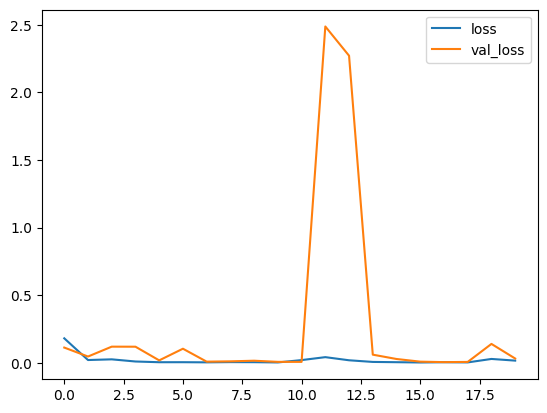

In [58]:
# Plotting training and validation loss
historyDf.loc[:, ['loss', 'val_loss']].plot()

<Axes: >

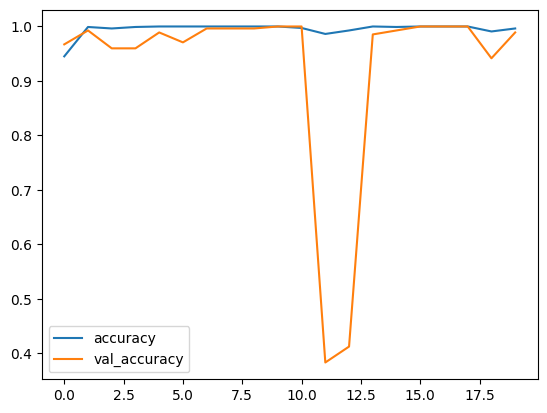

In [59]:
# Plotting training and validation accuracy
historyDf.loc[:, ['accuracy', 'val_accuracy']].plot()

In [60]:
# Evaluating model
score = cnn_model.evaluate(X_test, y_test_encoded)[1] * 100
print(f'Validation accuracy of model : {score:.2f}%')

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9925 - loss: 0.0125
Validation accuracy of model : 99.56%


In [61]:
# 두 번째 모델: SVM
svm_model = SVC(kernel='rbf', gamma='auto', C=1)

In [66]:
from sklearn.metrics import accuracy_score
from scipy.stats import mode
# 모델 학습
cnn_model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_validation, y_validation_encoded))

svm_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_encoded)

# 각 모델의 예측 결과 가져오기
cnn_predictions = cnn_model.predict(X_test)
svm_predictions = svm_model.predict(X_test.reshape(X_test.shape[0], -1))

# CNN 모델의 예측 결과를 클래스 레이블로 변환
cnn_pred_labels = np.argmax(cnn_predictions, axis=1)

# 두 모델의 예측 결과를 최빈값을 사용하여 앙상블 수행
ensemble_predictions = []
for cnn_pred, svm_pred in zip(cnn_pred_labels, svm_predictions):
    combined_pred = np.bincount([cnn_pred, svm_pred]).argmax()
    ensemble_predictions.append(combined_pred)

# 최종 예측 결과 평가
ensemble_accuracy = accuracy_score(y_test_encoded, ensemble_predictions)
print("Ensemble accuracy: {:.2f}%".format(ensemble_accuracy * 100))

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9934 - loss: 0.0203 - val_accuracy: 0.7956 - val_loss: 0.4416
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9959 - loss: 0.0115 - val_accuracy: 0.9781 - val_loss: 0.0566
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9975 - loss: 0.0062 - val_accuracy: 0.9343 - val_loss: 0.1732
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9916 - loss: 0.0299 - val_accuracy: 0.6971 - val_loss: 0.9387
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9960 - loss: 0.0140 - val_accuracy: 0.9270 - val_loss: 0.1781
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9998 - loss: 0.0019 - val_accuracy: 0.9927 - val_loss: 0.0209
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9995 - loss: 0.0029 - val_accuracy: 0.9964 - val_loss: 0.0192
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9997 - loss: 0.0056 - val_accuracy: 1.0000 - v

# DeepSpectrum(여기 밑에부터만 돌리면 돼요!)

#### WAV to Mel Spectogram 만들기 & 이미지로 저장하기

In [5]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def audio_to_spectrogram(file_path):
    y, sr = librosa.load(file_path)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram, sr  # 샘플링 레이트를 반환하여 나중에 사용

def audio_to_spectrogram2(file_path):
    y, sr = librosa.load(file_path)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram 
    
def save_spectrogram_image(spectrogram, sr, save_path):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

In [6]:
#AI WAV 파일을 Spectogram 이미지로 변환
import os

# 원본 WAV 파일이 있는 폴더와 변환된 Spec 파일을 저장할 폴더 경로 설정
input_folder = 'datasets/AI'  # WAV 파일이 있는 폴더
output_folder = 'datasets2/AI_spec'  # Spec 파일을 저장할 폴더

# 출력 폴더가 없으면 생성
os.makedirs(output_folder, exist_ok=True)

# 입력 폴더의 모든 파일을 순회
for filename in os.listdir(input_folder):
    if filename.endswith('.wav'):
        if filename == '.DS_Store':
            continue
        file_path = os.path.join(input_folder, filename)
        spec_filename = os.path.splitext(filename)[0] + '.png'
        spec_path = os.path.join(output_folder, spec_filename)
        
        spectrogram, sr = audio_to_spectrogram(file_path)
        
        save_spectrogram_image(spectrogram, sr, spec_path)
        
        print(f"{file_path}를 {spec_path}로 변환했습니다.")

print("모든 WAV 파일을 Spectrogram 파일로 변환했습니다.")


FileNotFoundError: [Errno 2] No such file or directory: 'datasets2/AI'

In [14]:
#Human WAV 파일을 Spectogram으로 변환
import os

# 원본 WAV 파일이 있는 폴더와 변환된 Spec 파일을 저장할 폴더 경로 설정
input_folder = 'datasets/Human'  # WAV 파일이 있는 폴더
output_folder = 'datasets2/Human_spec'  # Spec 파일을 저장할 폴더

# 출력 폴더가 없으면 생성
os.makedirs(output_folder, exist_ok=True)

# 입력 폴더의 모든 파일을 순회
for filename in os.listdir(input_folder):
    if filename.endswith('.wav'):
        if filename == '.DS_Store':
            continue
        file_path = os.path.join(input_folder, filename)
        spec_filename = os.path.splitext(filename)[0] + '.png'
        spec_path = os.path.join(output_folder, spec_filename)
        
        spectrogram, sr = audio_to_spectrogram(file_path)
        
        save_spectrogram_image(spectrogram, sr, spec_path)
        
        print(f"{file_path}를 {spec_path}로 변환했습니다.")

print("모든 WAV 파일을 Spectrogram 파일로 변환했습니다.")


datasets2/Human/[수정]20210129 163218.wav를 datasets3/Human_spec/[수정]20210129 163218.png로 변환했습니다.
datasets2/Human/[수정]20210126 223356.wav를 datasets3/Human_spec/[수정]20210126 223356.png로 변환했습니다.
datasets2/Human/[수정]20210128 212555.wav를 datasets3/Human_spec/[수정]20210128 212555.png로 변환했습니다.
datasets2/Human/[수정]20210128 152056.wav를 datasets3/Human_spec/[수정]20210128 152056.png로 변환했습니다.
datasets2/Human/[수정]20210126 230909.wav를 datasets3/Human_spec/[수정]20210126 230909.png로 변환했습니다.
datasets2/Human/[수정]20210128 202424.wav를 datasets3/Human_spec/[수정]20210128 202424.png로 변환했습니다.
datasets2/Human/[수정]20210129 130709.wav를 datasets3/Human_spec/[수정]20210129 130709.png로 변환했습니다.
datasets2/Human/[수정]20210128 203934.wav를 datasets3/Human_spec/[수정]20210128 203934.png로 변환했습니다.
datasets2/Human/[수정]20210128 205835.wav를 datasets3/Human_spec/[수정]20210128 205835.png로 변환했습니다.
datasets2/Human/[수정]20210129 193539.wav를 datasets3/Human_spec/[수정]20210129 193539.png로 변환했습니다.
datasets2/Human/[수정]20210129 125700.wav를 datasets3

In [8]:
audio_to_spectrogram('datasets/AI/[Full] 윈터 - 예뻤어 (데이식스)  aespa winter - You Were Beautiful (Day6) cover AI 커버.wav')

/var/folders/s4/y_mv_22949l2v878sknjf3g00000gn/T/ipykernel_947/2390485956.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path)


(array([[-71.63002, -69.00364, -68.11598, ..., -80.     , -80.     ,
         -80.     ],
        [-80.     , -80.     , -80.     , ..., -80.     , -80.     ,
         -80.     ],
        [-80.     , -80.     , -80.     , ..., -80.     , -80.     ,
         -80.     ],
        ...,
        [-80.     , -80.     , -80.     , ..., -80.     , -80.     ,
         -80.     ],
        [-80.     , -80.     , -80.     , ..., -80.     , -80.     ,
         -80.     ],
        [-80.     , -80.     , -80.     , ..., -80.     , -80.     ,
         -80.     ]], dtype=float32),
 22050)

In [10]:
audio_to_spectrogram('datasets/Human/3년 만에 너클 커브를 완성시킨 투수 이대은 shorts 최강야구.wav의 사본.wav')

(array([[-80.      , -80.      , -80.      , ..., -27.804405, -26.588478,
         -39.80556 ],
        [-80.      , -80.      , -80.      , ..., -21.667063, -23.620106,
         -39.823776],
        [-80.      , -80.      , -80.      , ..., -20.705994, -25.356789,
         -40.67853 ],
        ...,
        [-80.      , -80.      , -80.      , ..., -55.315304, -56.845535,
         -75.74982 ],
        [-80.      , -80.      , -80.      , ..., -61.096943, -63.000824,
         -80.      ],
        [-80.      , -80.      , -80.      , ..., -73.78618 , -75.491714,
         -80.      ]], dtype=float32),
 22050)

#### dataset 불러오기

In [32]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def audio_to_spectrogram2(file_path):
    y, sr = librosa.load(file_path)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram 

In [33]:
import os
import random
from tqdm import tqdm

def create_datasets(root, num) : 
    data = []
    
    # Iterating through the folders and files to extract features
    for folder in os.listdir(root):
        folderPath = os.path.join(root, folder)
        if folder in [".DS_Store", "label.csv", "datasets.json"]:
                continue
            
        all_files = os.listdir(folderPath)
        valid_files = [file for file in all_files if file != '.DS_Store']
        
        if len(valid_files) > num:
            files_to_process = random.sample(valid_files, num)
        else:
            files_to_process = valid_files
            
        for file in tqdm(files_to_process, desc = f'Processing folder {folder}'):
            filePath = os.path.join(folderPath, file)
            if file == '.DS_Store':
                continue
            try : 
                features = audio_to_spectrogram2(filePath)
            
                if features is not None:
                    data.append([features, folder, file])
                    
            except Exception as e:
                print(f"Error reading file {filePath}: {e}")
    return data

##### STS1_datasets

In [34]:
root = 'datasets/STS1_datasets_10s'
STS1_data = create_datasets(root, 3000)

Processing folder AI: 100%|█████████████████| 2834/2834 [00:36<00:00, 77.02it/s]


##### STS2_datasets

In [35]:
import os
import random
from tqdm import tqdm

root = 'datasets/STS2_datasets_10s'
STS2_data = create_datasets(root, 1100)

Processing folder AI: 100%|█████████████████| 1049/1049 [00:11<00:00, 88.68it/s]


##### STS3_datasets

In [36]:
import os
import random
from tqdm import tqdm

root = 'datasets/STS3_datasets_10s'
STS3_data = create_datasets(root, 3100)

Processing folder AI: 100%|█████████████████| 3082/3082 [00:35<00:00, 85.88it/s]


##### Human_datasets

In [37]:
import os
import random
from tqdm import tqdm

root = 'datasets/Human_datasets_10s'
Human_data = create_datasets(root, 3300)

Processing folder Human: 100%|██████████████| 3264/3264 [00:48<00:00, 67.79it/s]


##### 각 폴더에서 불러온 datasets 합치기

In [38]:
data = STS1_data + STS2_data + STS3_data + Human_data

In [39]:
import pandas as pd

# Converting list into dataframe
data = pd.DataFrame(data, columns = ['Features', 'Class', 'File Name'])
data.head()

,Features,Class,File Name
0,"[[-80.0, -80.0, -72.33777, -51.089428, -42.264...",AI,AI_1_금감원_인간음성_52_18_1.wav
1,"[[-80.0, -80.0, -80.0, -54.857285, -43.48955, ...",AI,AI_1_MBC 라디오 사연 하이라이트 엠라대왕 41...
2,"[[-80.0, -80.0, -80.0, -63.731506, -52.125282,...",AI,AI_1_금감원_인간음성_53_18_1.wav
3,"[[-80.0, -80.0, -71.883804, -51.05206, -42.122...",AI,AI_1_[수정]20210126 224320_5_1.wav
4,"[[-80.0, -80.0, -80.0, -59.00141, -47.686546, ...",AI,AI_1_MBC 라디오 사연 하이라이트 엠라대왕 49...


In [40]:
data = data.sort_values(by=['File Name'], ascending=[True])
data

,Features,Class,File Name
2211,"[[-38.065804, -40.310173, -38.88968, -41.01819...",AI,AI_1_180도 변한 민희진…뜻밖 비밀 돌출...
438,"[[-32.192085, -25.534187, -25.470627, -31.3178...",AI,AI_1_1심 무죄 이재명 사법부에 감사…도민 ᄉ...
188,"[[-80.0, -80.0, -74.08569, -52.403076, -43.598...",AI,AI_1_2시간과 목숨을 바꾸시겠습니까_3_1.wav
96,"[[-50.166687, -47.177063, -44.310516, -46.7752...",AI,AI_1_2차선에 차량 세운 이유 모르겠다…남펴...
1332,"[[-80.0, -80.0, -72.869865, -51.30198, -41.305...",AI,AI_1_3등이 노력 없이 1등을 이기는 법_1_...
...,...,...,...
10015,"[[-78.09742, -61.89204, -53.436478, -53.43213,...",Human,금감원_인간음성_94_5_1.wav
9091,"[[-66.78873, -57.772045, -58.608673, -64.36488...",Human,금감원_인간음성_94_6_1.wav
10042,"[[-51.282494, -55.339493, -55.991875, -54.2475...",Human,금감원_인간음성_94_7_1.wav
7884,"[[-79.25636, -78.03104, -80.0, -80.0, -80.0, -...",Human,금감원_인간음성_94_8_1.wav


/var/folders/s4/y_mv_22949l2v878sknjf3g00000gn/T/ipykernel_983/3844386615.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=data['Class'], palette='viridis')


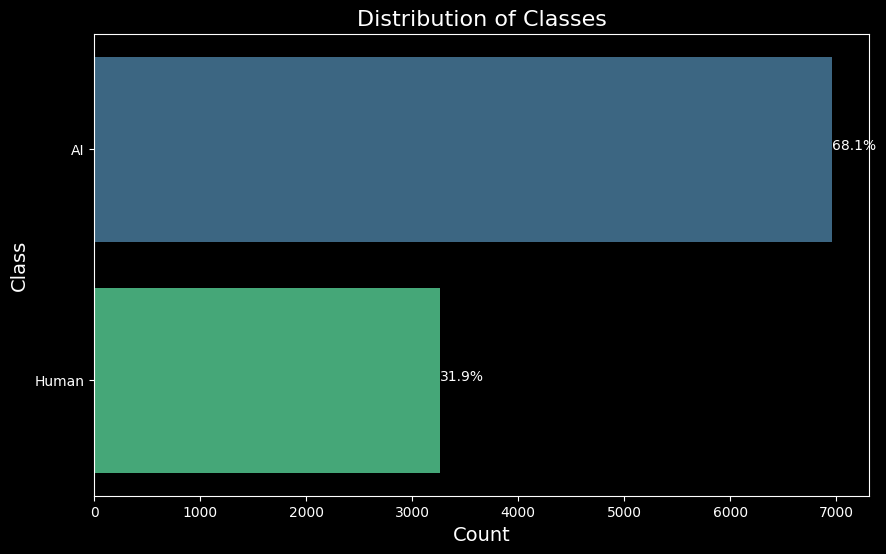

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
ax = sns.countplot(y=data['Class'], palette='viridis')

total = len(data['Class'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

plt.title('Distribution of Classes', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Class', fontsize=14)
plt.show()


In [42]:
data['Features'][2].shape

(128, 455)

In [43]:
from keras.preprocessing.sequence import pad_sequences

# Padding or truncating the arrays to a fixed length
x = data['Features']
#x = pad_sequences(x, dtype = 'float32', padding = 'post', truncating = 'post')
x

2211     [[-38.065804, -40.310173, -38.88968, -41.01819...
438      [[-32.192085, -25.534187, -25.470627, -31.3178...
188      [[-80.0, -80.0, -74.08569, -52.403076, -43.598...
96       [[-50.166687, -47.177063, -44.310516, -46.7752...
1332     [[-80.0, -80.0, -72.869865, -51.30198, -41.305...
                               ...                        
10015    [[-78.09742, -61.89204, -53.436478, -53.43213,...
9091     [[-66.78873, -57.772045, -58.608673, -64.36488...
10042    [[-51.282494, -55.339493, -55.991875, -54.2475...
7884     [[-79.25636, -78.03104, -80.0, -80.0, -80.0, -...
7212     [[-37.508095, -42.915333, -57.98645, -52.10347...
Name: Features, Length: 10229, dtype: object

In [44]:
x[1].shape

(128, 559)

##### x값 Padding

In [45]:
# MAX값으로 패딩하기
import numpy as np

# 데이터셋의 모든 샘플의 크기를 확인하여 가장 큰 샘플의 크기를 찾습니다.
max_second_dimension = max(sample.shape[1] for sample in x)
max_second_dimension

646

In [14]:
# 각 샘플을 패딩하여 두 번째 차원의 크기를 맞춥니다.
padded_x = []
for sample in x:
    pad_width = max_second_dimension - sample.shape[1]
    padded_sample = np.pad(sample, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    padded_x.append(padded_sample)

# 패딩된 데이터셋을 넘파이 배열로 변환합니다.
padded_x = np.array(padded_x)

# 패딩된 데이터셋의 형태를 확인합니다.
print("Padded dataset shape:", padded_x.shape)

Padded dataset shape: (6883, 128, 646)


In [46]:
# 평균값으로 패딩하기
import numpy as np

# 데이터셋의 모든 샘플의 크기를 확인하여 두 번째 차원의 평균 크기를 계산합니다.
mean_second_dimension = int(np.mean([sample.shape[1] for sample in x]))
print("Mean second dimension size:", mean_second_dimension)

Mean second dimension size: 607


In [ ]:
# 각 샘플을 패딩 또는 자르기하여 두 번째 차원의 크기를 평균 크기로 맞춥니다.
padded_x = []
for sample in x:
    if sample.shape[1] < mean_second_dimension:
        # 패딩
        pad_width = mean_second_dimension - sample.shape[1]
        padded_sample = np.pad(sample, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    else:
        # 자르기
        padded_sample = sample[:, :mean_second_dimension]
    padded_x.append(padded_sample)

# 패딩된 데이터셋을 넘파이 배열로 변환합니다.
padded_x = np.array(padded_x)

# 패딩된 데이터셋의 형태를 확인합니다.
print("Padded dataset shape:", padded_x.shape)

In [47]:
# 최빈값으로 패딩하기
import statistics

# 데이터셋의 모든 샘플의 크기를 확인하여 두 번째 차원의 평균 크기를 계산합니다.
mode_second_dimension = int(statistics.mode([sample.shape[1] for sample in x]))
print("Mode second dimension size:", mode_second_dimension)

Mode second dimension size: 646


In [48]:
# 각 샘플을 패딩 또는 자르기하여 두 번째 차원의 크기를 평균 크기로 맞춥니다.
padded_x = []
for sample in x:
    if sample.shape[1] < mode_second_dimension:
        # 패딩
        pad_width = mode_second_dimension - sample.shape[1]
        padded_sample = np.pad(sample, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    else:
        # 자르기
        padded_sample = sample[:, :mode_second_dimension]
    padded_x.append(padded_sample)

# 패딩된 데이터셋을 넘파이 배열로 변환합니다.
padded_x = np.array(padded_x)

# 패딩된 데이터셋의 형태를 확인합니다.
print("Padded dataset shape:", padded_x.shape)

Padded dataset shape: (10229, 128, 646)


##### Train/Test split

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Encoding class labels
encoder = LabelEncoder()
y = encoder.fit_transform(data['Class'])
y = to_categorical(y)

In [50]:
# Train-validation split
trainX, testX, trainY, testY = train_test_split(padded_x, y, random_state = 99)

In [51]:
trainX.shape

(7671, 128, 646)

In [86]:
trainX[1].shape

(128, 646)

#### CNN 모델 선언

In [52]:
from keras import layers, Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
'''
model = Sequential([
    layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'same', input_shape = (128, 646, 1)),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(64, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(2, activation = 'softmax')
])'''
'''
model = Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(128, 646, 1)),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    
    layers.Dense(32, activation='relu'),  # 축소된 Dense layer
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(2, activation='softmax')
])
'''

model = Sequential([
    layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'same', input_shape = (128, 646, 1)),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(64, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(2, activation = 'softmax')
])

# 옵티마이저를 정의하고 learning rate를 설정합니다.
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

#model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Displaying model architecture
model.summary()

/opt/anaconda3/envs/iot_deepfake/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 128, 646, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 323, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 323, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 323, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 661504)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │    42,336,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,337,154 (161.50 MB)

 Trainable params: 42,336,962 (161.50 MB)

 Non-trainable params: 192 (768.00 B)

In [54]:
history = model.fit(
    trainX, trainY,
    validation_data = (testX, testY),
    epochs = 50,
    batch_size=8,
    #callbacks = [earlyStopping]
)  

Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - accuracy: 0.6780 - loss: 0.6595 - val_accuracy: 0.8088 - val_loss: 0.4832
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 49s 51ms/step - accuracy: 0.8650 - loss: 0.3131 - val_accuracy: 0.9281 - val_loss: 0.2016
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 50s 52ms/step - accuracy: 0.9279 - loss: 0.1977 - val_accuracy: 0.9265 - val_loss: 0.1725
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 50s 52ms/step - accuracy: 0.9415 - loss: 0.1617 - val_accuracy: 0.9500 - val_loss: 0.2323
Epoch 5/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 50s 52ms/step - accuracy: 0.9556 - loss: 0.1288 - val_accuracy: 0.8905 - val_loss: 0.2921
Epoch 6/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 53s 56ms/step - accuracy: 0.9627 - loss: 0.1116 - val_accuracy: 0.9609 - val_loss: 0.1194
Epoch 7/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 54s 56ms/step - accuracy: 0.9673 - loss: 0.0943 - val_accuracy: 0.9550 - val_loss: 0.1460
Epoch 8/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 57s 59ms/step - accuracy: 0.9705 - loss: 0.0893 - 

In [194]:
# 모델 저장
model.save('deepspectrum_AIvoice.h5')

In [55]:
historyDf = pd.DataFrame(history.history)

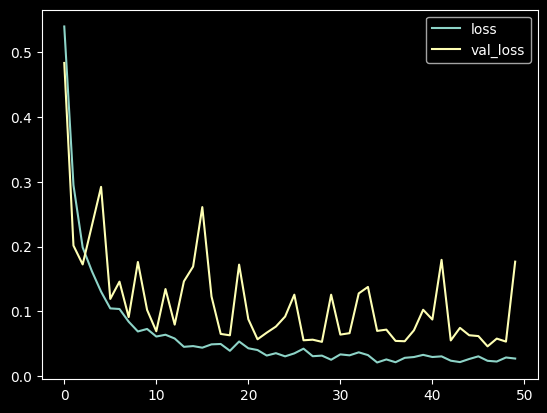

In [57]:
import matplotlib.pyplot as plt

# Assuming historyDf is your DataFrame containing 'loss' and 'val_loss'

# Create a figure and axis objects
fig, ax = plt.subplots()

# Plot 'loss' and 'val_loss' with black background
historyDf.loc[:, ['loss', 'val_loss']].plot(ax=ax)

# Set background color to black
#ax.set_facecolor('black')
#plt.style.use('dark_background')
plt.style.use('grayscale') 
# Show the plot
plt.show()

<Axes: >

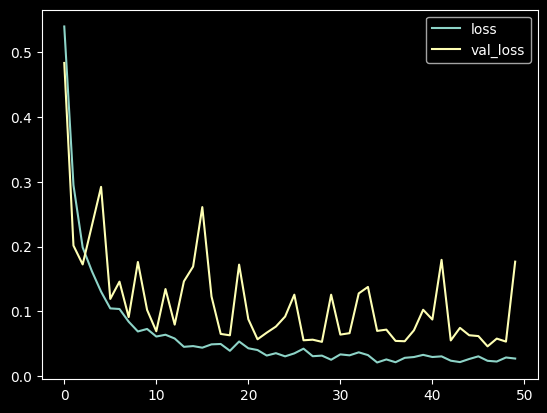

In [56]:
# Plotting training and validation loss
historyDf.loc[:, ['loss', 'val_loss']].plot()

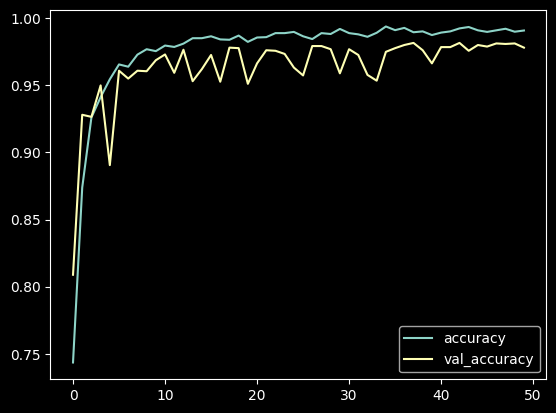

In [70]:
import matplotlib.pyplot as plt

# Assuming historyDf is your DataFrame containing 'loss' and 'val_loss'

# Create a figure and axis objects
fig, ax = plt.subplots()

# Plot 'loss' and 'val_loss' with black background
historyDf.loc[:, ['accuracy', 'val_accuracy']].plot(ax=ax)

# Set background color to black
#ax.set_facecolor('black')
plt.style.use('dark_background')
#plt.style.use('grayscale') 
# Show the plot
plt.show()

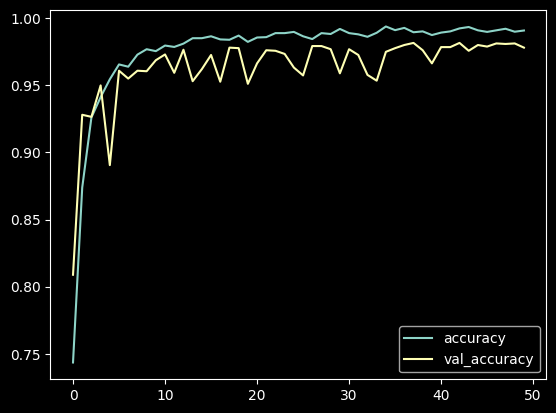

In [61]:
# Plotting training and validation accuracy
historyDf.loc[:, ['accuracy', 'val_accuracy']].plot()

# Show the plot
plt.show()

In [115]:
# Evaluating model
score = model.evaluate(testX, testY)[1] * 100
print(f'Validation accuracy of model : {score:.2f}%')

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8936 - loss: 0.3988
Validation accuracy of model : 90.27%


### 아래는 earlystop 적용 버전

In [ ]:
earlyStopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    min_delta = 0.001,
    restore_best_weights = True
)

In [62]:
history2 = model.fit(
    trainX, trainY,
    validation_data = (testX, testY),
    epochs = 50,
    batch_size=8,
    callbacks = [earlyStopping]
)  

Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 50s 52ms/step - accuracy: 0.9897 - loss: 0.0320 - val_accuracy: 0.9652 - val_loss: 0.1014
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 50s 52ms/step - accuracy: 0.9917 - loss: 0.0227 - val_accuracy: 0.9762 - val_loss: 0.0710
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 49s 52ms/step - accuracy: 0.9916 - loss: 0.0256 - val_accuracy: 0.9812 - val_loss: 0.0596
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 50s 52ms/step - accuracy: 0.9916 - loss: 0.0256 - val_accuracy: 0.9789 - val_loss: 0.0766
Epoch 5/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 50s 52ms/step - accuracy: 0.9921 - loss: 0.0239 - val_accuracy: 0.9765 - val_loss: 0.0721
Epoch 6/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 50s 52ms/step - accuracy: 0.9927 - loss: 0.0219 - val_accuracy: 0.9855 - val_loss: 0.0475
Epoch 7/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 51s 54ms/step - accuracy: 0.9928 - loss: 0.0215 - val_accuracy: 0.9859 - val_loss: 0.0515
Epoch 8/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 52s 54ms/step - accuracy: 0.9946 - loss: 0.0183 - 

In [66]:
historyDf2 = pd.DataFrame(history2.history)

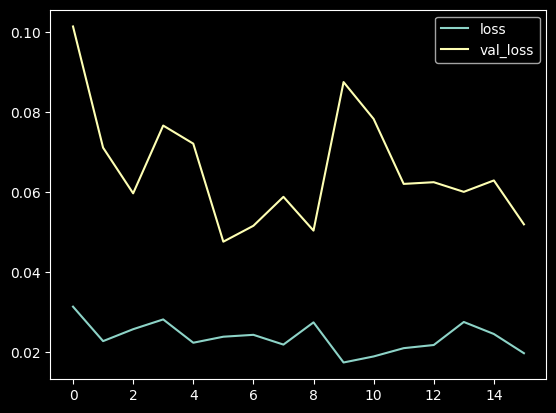

In [67]:
import matplotlib.pyplot as plt

# Assuming historyDf is your DataFrame containing 'loss' and 'val_loss'

# Create a figure and axis objects
fig, ax = plt.subplots()

# Plot 'loss' and 'val_loss' with black background
historyDf2.loc[:, ['loss', 'val_loss']].plot(ax=ax)

# Set background color to black
#ax.set_facecolor('black')
#plt.style.use('dark_background')
plt.style.use('grayscale') 
# Show the plot
plt.show()

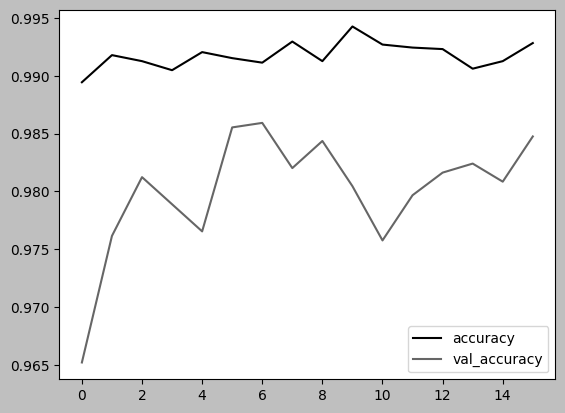

In [68]:
import matplotlib.pyplot as plt

# Assuming historyDf is your DataFrame containing 'loss' and 'val_loss'

# Create a figure and axis objects
fig, ax = plt.subplots()

# Plot 'loss' and 'val_loss' with black background
historyDf2.loc[:, ['accuracy', 'val_accuracy']].plot(ax=ax)

# Set background color to black
#ax.set_facecolor('black')
plt.style.use('dark_background')
#plt.style.use('grayscale') 
# Show the plot
plt.show()

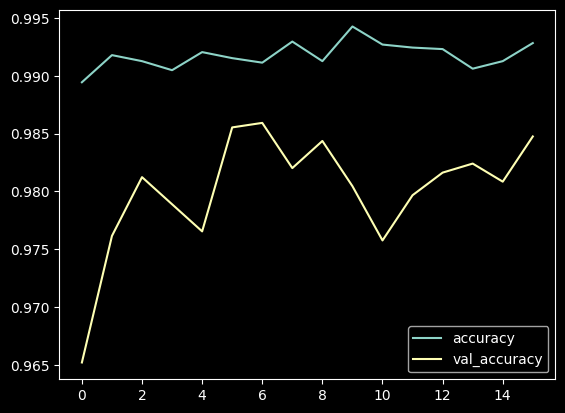

In [69]:
# Plotting training and validation accuracy
historyDf2.loc[:, ['accuracy', 'val_accuracy']].plot()

# Show the plot
plt.show()